In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import dask.array as da

import snapfish2 as sf
from utils import out_dire
from utils.data import DataTree
dtree = DataTree("../data")

In [2]:
%reload_ext autoreload
%autoreload 2

## Sox2 5Kb 41 Loci

In [3]:
adata_sox2 = sf.pp.FOF_CT_Loader(
    dtree["huang_ng_2021", "between"]).create_adata("chr3")
for c in "XYZ":
    adata_sox2.layers[c][:,25] = np.nan
allele = adata_sox2.obs.index.str.replace(r"^.*_", "", regex=True)
adata_sox2.obs["allele"] = allele

cast = adata_sox2[adata_sox2.obs["allele"]=="CAST"].copy()
c129 = adata_sox2[adata_sox2.obs["allele"]=="129"].copy()

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/snapfish2/utils/load.py:207: UserWarning: FOF_CT-core data has less columns than what specified in the header. Additional columns will be ignored.
  warnings.warn(


In [4]:
sf.pp.filter_normalize(cast)
raw_var = np.stack([cast.varp[f"raw_var_{c}"] for c in "XYZ"])

/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


In [5]:
d1d = cast.var.Chrom_Start.values
warnings.filterwarnings("ignore", "divide by zero")
log_d1map = np.log(np.abs(d1d[None,:] - d1d[:,None]))
warnings.filterwarnings("default")

uidx = np.triu_indices(log_d1map.shape[0], k=1)
raw_strata_var = sf.pp.eval._local_linear_regression(
    log_d1map, log_d1map[uidx], np.log(raw_var[:,*uidx])
)


AttributeError: module 'snapfish2.utils.eval' has no attribute '_local_linear_regression'

In [38]:
from statsmodels.nonparametric.smoothers_lowess import lowess
def lowess_multivariate(log_d1map, xs, ys):
    strata_var = np.zeros((ys.shape[0], *log_d1map.shape))*np.nan
    uidx = np.triu_indices_from(log_d1map, k=1)
    
    for i, y in enumerate(ys):
        strata_var[i][uidx] = lowess(y, xs, frac=.1, return_sorted=False)
        strata_var[i].T[uidx] = strata_var[i][uidx]
    return np.exp(strata_var)
aa = np.log(raw_var[:,*uidx])
aa[0,0] = np.nan
lowess_strata_var = lowess_multivariate(
    log_d1map, log_d1map[uidx], aa
)

In [34]:
a = 0
plt_df = pd.DataFrame({
    "1d": np.exp(log_d1map[uidx]),
    "var": raw_var[a][uidx],
    "strata_var": raw_strata_var[a][uidx],
    "lowess_strata_var": lowess_strata_var[a][uidx]
})

<Axes: xlabel='1d', ylabel='var'>

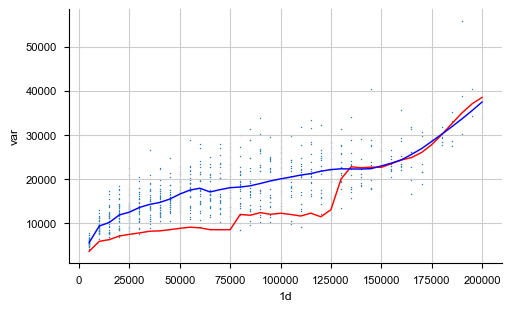

In [35]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.scatterplot(plt_df, x="1d", y="var", ax=ax, s=1)
sns.lineplot(plt_df, x="1d", y="strata_var", ax=ax, color="red", linewidth=1)
sns.lineplot(plt_df, x="1d", y="lowess_strata_var", ax=ax, color="blue", linewidth=1)
# ax.set(xlim=(0, 1e6), ylim=(0, 5e5))

In [39]:
lowess_z = lowess(log_d1map[uidx], np.log(raw_var[0][uidx]))
lowess_z

array([[ 8.26092423,  7.9054119 ],
       [ 8.305243  ,  8.00102493],
       [ 8.328845  ,  8.0520633 ],
       ...,
       [10.60779277, 12.12347744],
       [10.60797056, 12.12366766],
       [10.93077615, 12.46526353]])

In [14]:
sf.pp.eval._local_linear_regression

<function snapfish2.utils.eval._local_linear_regression(log_d1map: numpy.ndarray, xs: numpy.ndarray, ys: numpy.ndarray) -> numpy.ndarray>

## A pair is never observed

In [3]:
loader = sf.pp.FOF_CT_Loader({
    "rep1": dtree["takei_nature_2021", "25Kb", "rep1"],
    "rep2": dtree["takei_nature_2021", "25Kb", "rep2"]
}, voxel_ratio={"X": 1000, "Y": 1000, "Z": 1000})
adata1 = loader.create_adata("chr15")

In [ ]:
sub_adata = adata1[adata1.obs.sample(100).index].copy()
sf.pp.filter_normalize(sub_adata)

/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


In [9]:
sub_adata.varp["count_X"].sum()

156552

In [10]:
adata = sub_adata

n = adata.shape[0]
# Size of n*d*c*c = 1GB
c = round(1 * (n * 3 * 8 / 1e9) ** -0.5)

X = da.from_array(np.stack([
    adata.layers[c] for c in "XYZ"
]), chunks=(3,n,c))
arr = X[:,:,:,None] - X[:,:,None,:]

d1d = adata.var["Chrom_Start"].values
warnings.filterwarnings("ignore", "divide by zero")
log_d1map = np.log(np.abs(d1d[None,:] - d1d[:,None]))
warnings.filterwarnings("default")

In [12]:
raw_var = da.nanmedian(da.square(
    arr - da.nanmedian(arr, axis=1, keepdims=True)
), axis=1).compute()
raw_var[np.isclose(raw_var, 0)] = np.nan

for i, v in enumerate("XYZ"):
    adata.varp[f"raw_var_{v}"] = raw_var[i]
    
uidx = np.triu_indices(log_d1map.shape[0], k=1)
raw_strata_var = sf.pp.eval._local_linear_regression(
    log_d1map, log_d1map[uidx], np.log(raw_var[:,*uidx])
)

In [13]:
raw_var[:,*uidx][np.isclose(raw_var[:,*uidx], 0)] = np.nan

In [14]:
raw_var[:,*uidx][np.isclose(raw_var[:,*uidx], 0)]

array([], dtype=float64)

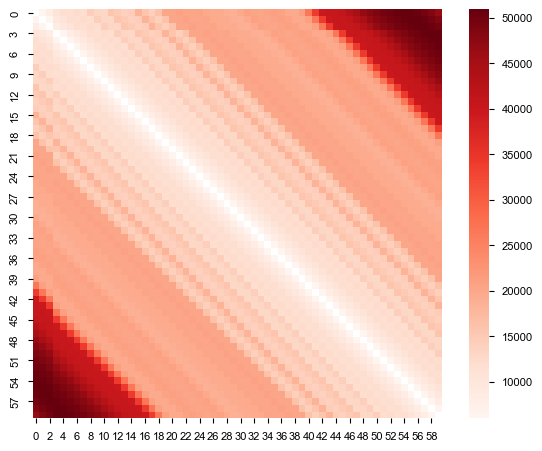

In [15]:
ax = sns.heatmap(raw_strata_var[0], cmap="Reds", square=True)
ax.grid(False)

In [16]:
np.where(np.isnan(np.log(raw_var[:,*uidx])))

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2]),
 array([ 17,  75, 132, 188, 243, 297, 350, 402, 453, 503, 552, 600, 647,
        693, 738, 782, 825, 867, 909, 910, 911, 912, 913, 914, 915, 916,
        917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929,
        930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942,
        943, 944, 945, 946, 947, 948, 949,  17,  75, 132, 188, 243, 297,
        350, 402, 453, 503, 55

In [93]:
sub_adata.varp["var_X"]

array([[       nan, 1.31832242, 1.43178654, ..., 1.03412298, 1.0953913 ,
        0.86324045],
       [1.31832242,        nan, 0.9995077 , ..., 1.08732809, 1.12100129,
        0.89185565],
       [1.43178654, 0.9995077 ,        nan, ..., 1.01687117, 1.04415693,
        1.06811973],
       ...,
       [1.03412298, 1.08732809, 1.01687117, ...,        nan, 2.15824514,
        1.93852389],
       [1.0953913 , 1.12100129, 1.04415693, ..., 2.15824514,        nan,
        1.06475469],
       [0.86324045, 0.89185565, 1.06811973, ..., 1.93852389, 1.06475469,
               nan]])

In [4]:
adata2 = ad.read_h5ad(os.path.join(out_dire, \
    "../../123ACElog/071125/chr1_wild_rep11.h5ad"))

In [5]:
adata3 = sf.pp.FOF_CT_Loader("../data/su_cell_2020/chromosome2_\
p-arm_replicate.csv").create_adata("chr2")[:1000,:].copy()

In [6]:
adatas = [adata1, adata2, adata3]

In [7]:
def _add_med_var(adata):
    n = adata.shape[0]
    # Size of n*d*c*c = 1GB
    c = round(1 * (n * 3 * 8 / 1e9) ** -0.5)
    
    val_cols = ["X", "Y", "Z"]
    X = da.from_array(np.stack([
        adata.layers[c] for c in val_cols
    ]), chunks=(3,n,c))
    arr = X[:,:,:,None] - X[:,:,None,:]
    
    med_sq = da.nanmedian(da.square(
        arr - da.nanmean(arr, axis=1, keepdims=True)
    ), axis=1).compute()
    for i, v in enumerate(val_cols):
        adata.varp[f"raw_var_{v}"] = med_sq[i]
for adata in adatas:
    _add_med_var(adata)

In [58]:
def _local_linear_regression(log_d1map, xs, ys):
    num_nbrs = len(xs) // 10
    xi = np.array([1, 0, 0, 0])
    strata_var = np.zeros((ys.shape[0], *log_d1map.shape))*np.nan
    for x, c in zip(*np.unique(xs, return_counts=True)):
        if c > num_nbrs:
            Yi = np.nanmean(ys[:, xs==x], axis=1)
        else:
            diff = np.abs(xs - x)
            r = np.sort(diff)[num_nbrs]/3
            kept = diff <= 3*r
            xr = xs[kept] - x
            Xr = np.vstack([np.ones(len(xr)), xr, xr**2, xr**3]).T
            Yr = ys[:, kept]

            # Weight matrix (inverse of variance matrix in GLS)
            W = np.exp(-np.square(xr/r)/2)
            WX = W[:,None]*Xr
            P = xi@np.linalg.pinv(WX.T@Xr)@WX.T
            Yi = np.nansum(P[None,:]*Yr, axis=1)
        strata_var[:, log_d1map==x] = np.exp(Yi[:,None])
    return strata_var

In [9]:
def _filter_pdiff(adata, arr, log_d1map):
    raw_var = da.nanmedian(da.square(
        arr - da.nanmedian(arr, axis=1, keepdims=True)
    ), axis=1).compute()
    
    for i, v in enumerate("XYZ"):
        adata.varp[f"raw_var_{v}"] = raw_var[i]
        
    uidx = np.triu_indices(log_d1map.shape[0], k=1)
    raw_strata_var = _local_linear_regression(
        log_d1map, log_d1map[uidx], np.log(raw_var[:,*uidx])
    )
    
    strata_std = np.sqrt(raw_strata_var)[:,None,:,:]
    arr[da.abs(
        arr - da.nanmedian(arr, axis=1, keepdims=True)
    ) > strata_std*4] = np.nan

In [10]:
def _normalize_pdiff(adata, arr, log_d1map):
    count = da.sum(~da.isnan(arr), axis=1).compute()
    for i, c in enumerate("XYZ"):
        adata.varp[f"count_{c}"] = count[i]

    filtered_var = da.nanmean(da.square(
        arr - da.nanmean(arr, axis=1, keepdims=True)
    ), axis=1).compute()
    
    uidx = np.triu_indices(log_d1map.shape[0], k=1)
    filtered_strata_var = _local_linear_regression(
        log_d1map, log_d1map[uidx], np.log(filtered_var[:,*uidx])
    )
    # Normalize by std <-> divide by strata variance
    normalized_var = filtered_var/filtered_strata_var
    for i, c in enumerate("XYZ"):
        adata.varp[f"var_{c}"] = normalized_var[i]

In [11]:
adata = adata1

n = adata.shape[0]
# Size of n*d*c*c = 1GB
c = round(1 * (n * 3 * 8 / 1e9) ** -0.5)

X = da.from_array(np.stack([
    adata.layers[c] for c in "XYZ"
]), chunks=(3,n,c))
arr = X[:,:,:,None] - X[:,:,None,:]

d1d = adata.var["Chrom_Start"].values
warnings.filterwarnings("ignore", "divide by zero")
log_d1map = np.log(np.abs(d1d[None,:] - d1d[:,None]))
warnings.filterwarnings("default")

In [12]:
_filter_pdiff(adata, arr, log_d1map)
_normalize_pdiff(adata, arr, log_d1map)

/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


In [13]:
d1d = adata.var["Chrom_Start"].values
warnings.filterwarnings("ignore", "divide by zero")
log_d1map = np.log(np.abs(d1d[None,:] - d1d[:,None]))
warnings.filterwarnings("default")
uidx = np.triu_indices(log_d1map.shape[0], k=1)

In [14]:
raw_var = da.nanmedian(da.square(
    arr - da.nanmedian(arr, axis=1, keepdims=True)
), axis=1).compute()

/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


In [15]:
raw_strata_var = _local_linear_regression(
    log_d1map, log_d1map[uidx], np.log(raw_var[:,*uidx])
)

In [16]:
strata_std = np.sqrt(raw_strata_var)[:,None,:,:]
arr[da.abs(
    arr - da.nanmedian(arr, axis=1, keepdims=True)
) > strata_std*4] = np.nan

count = da.sum(~da.isnan(arr), axis=1).compute()
# for i, c in enumerate(["X", "Y", "Z"]):
#     adata.varp[f"count_{c}"] = count[i]

filtered_var = da.nanmean(da.square(
    arr - da.nanmean(arr, axis=1, keepdims=True)
), axis=1).compute()

In [17]:
count[0].sum()

1363172

In [19]:
adata.varp["count_X"].sum()

1367462

In [20]:
filtered_strata_var = _local_linear_regression(
    log_d1map, log_d1map[uidx], np.log(filtered_var[:,*uidx])
)
# Normalize by std <-> divide by strata variance
normalized_var = filtered_var/filtered_strata_var

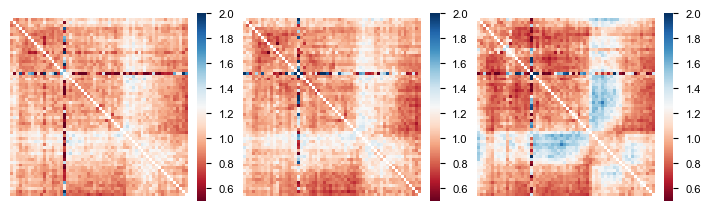

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(7, 2))
for ax, mat in zip(axes, normalized_var):
    sf.pl.pairwise_heatmap(mat, ax=ax, vmin=.5, vmax=2)

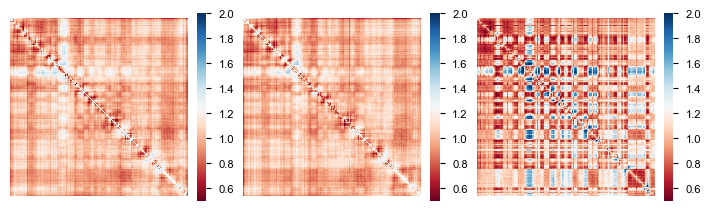

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(7, 2))
for ax, c in zip(axes, ["X", "Y", "Z"]):
    sf.pl.pairwise_heatmap(adata.varp[f"var_{c}"], ax=ax, vmin=.5, vmax=2)

In [17]:
sf.pp.filter_normalize(adata3)

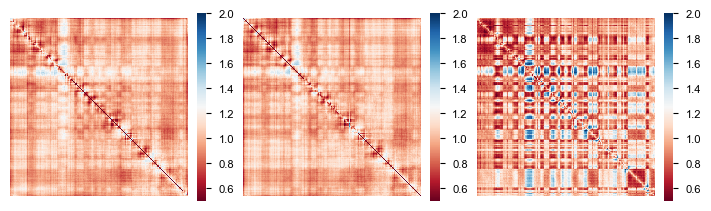

In [251]:
fig, axes = plt.subplots(1, 3, figsize=(7, 2))
for ax, c in zip(axes, ["X", "Y", "Z"]):
    sf.pl.pairwise_heatmap(adata3.varp[f"var_{c}"], ax=ax, vmin=.5, vmax=2)

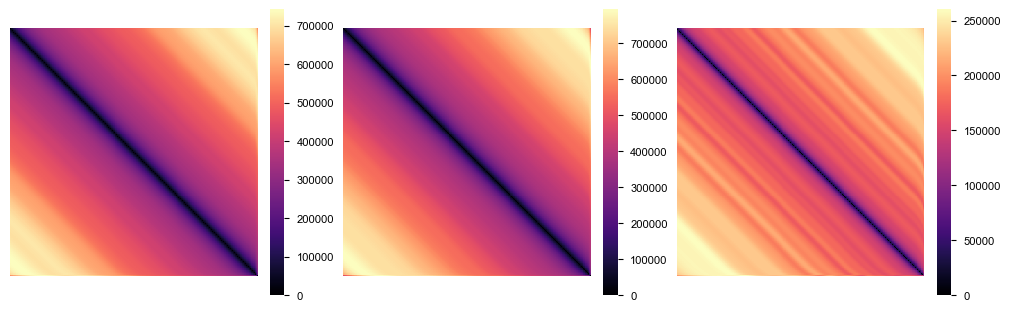

In [202]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for ax, var_1d in zip(axes, strata_var):
    sf.pl.pairwise_heatmap(var_1d, ax=ax, cmap="magma")

In [82]:
plt_df = pd.DataFrame({"1d": np.exp(log_d1map)[uidx]})
for i, c in enumerate(["X", "Y", "Z"]):
    plt_df[f"raw_var_{c}"] = raw_var[i,*uidx]
    plt_df[f"strata_var_{c}"] = raw_strata_var[i,*uidx]

<Axes: xlabel='1d', ylabel='raw_var_Z'>

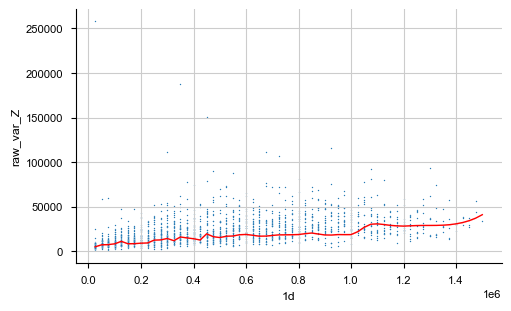

In [83]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.scatterplot(plt_df, x="1d", y="raw_var_Z", ax=ax, s=1)
sns.lineplot(plt_df, x="1d", y="strata_var_Z", ax=ax, color="red", linewidth=1)
# ax.set(xlim=(0, 1e6), ylim=(0, 5e5))

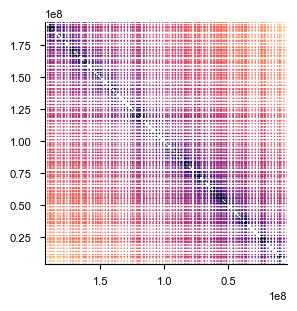

In [129]:
x1d = (d1d - np.zeros_like(d1d)[:,None])[uidx]
y1d = (d1d[:,None] - np.zeros_like(d1d))[uidx]

fig, ax = plt.subplots(figsize=(3, 3))
ax.set_box_aspect(1)
sns.scatterplot(x=x1d, y=y1d, hue=var_1d[uidx], palette="magma",
                linewidth=0, s=1, ax=ax)
sns.scatterplot(y=x1d, x=y1d, hue=var_1d[uidx], palette="magma",
                linewidth=0, s=1, ax=ax)
ax.legend().remove()
ax.grid(False)
ax.set(xlim=(d1d.min(), d1d.max()), ylim=(d1d.min(), d1d.max()))
ax.invert_xaxis()

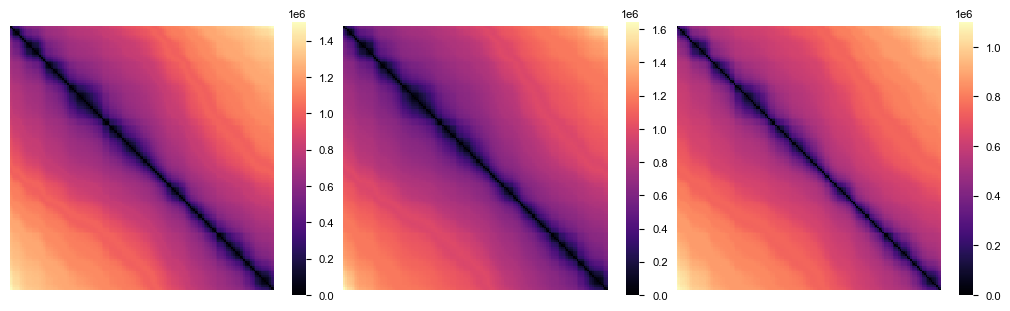

In [164]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for ax, var_1d in zip(axes, strata_var):
    sf.pl.pairwise_heatmap(var_1d, ax=ax, cmap="magma")

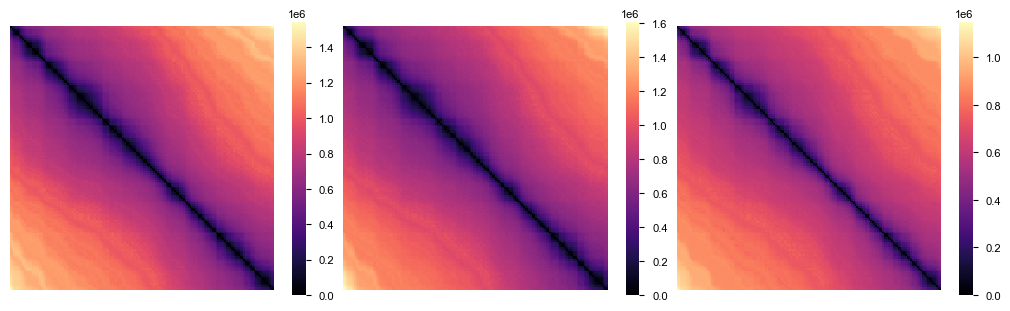

In [136]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for ax, var_1d in zip(axes, strata_var):
    sf.pl.pairwise_heatmap(var_1d, ax=ax, cmap="magma")

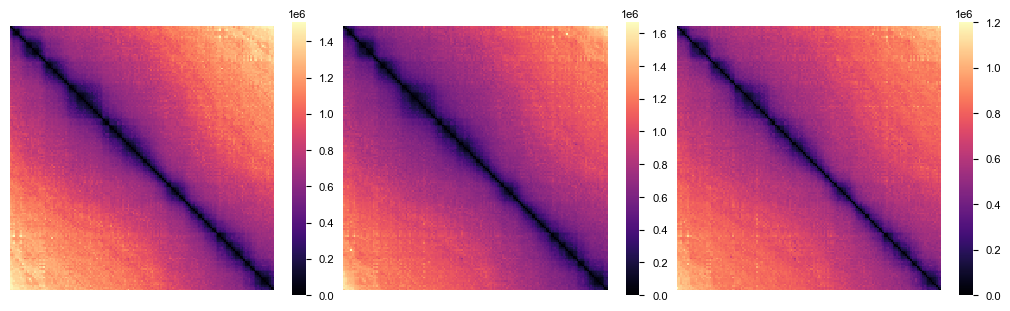

In [122]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for ax, var_1d in zip(axes, strata_var):
    sf.pl.pairwise_heatmap(var_1d, ax=ax, cmap="magma")

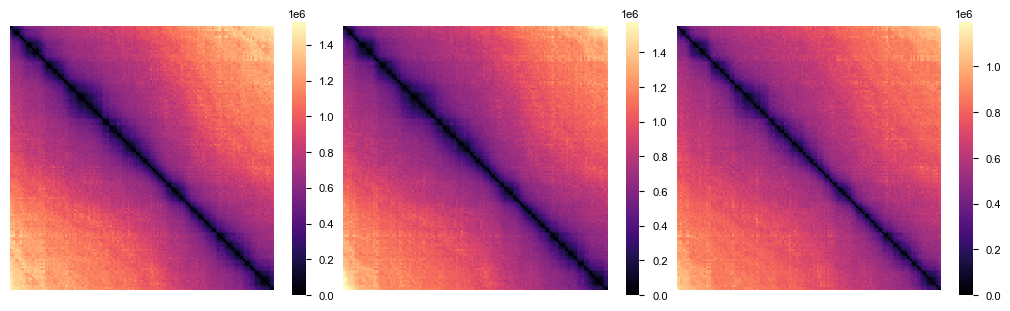

In [127]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for ax, var_1d in zip(axes, strata_var):
    sf.pl.pairwise_heatmap(var_1d, ax=ax, cmap="magma")

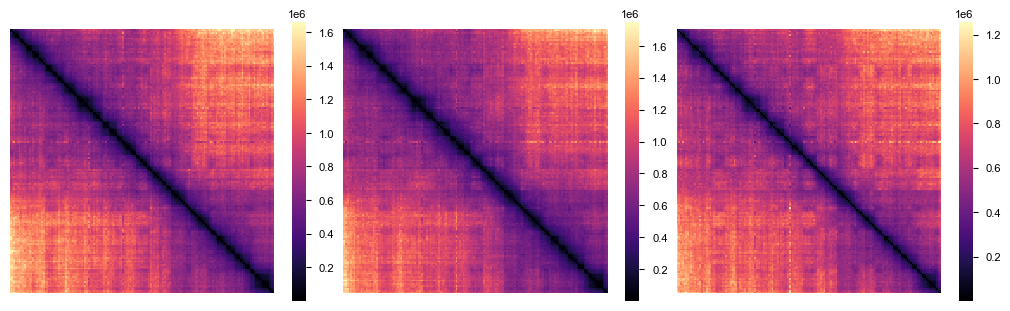

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for ax, var_1d in zip(axes, raw_var):
    sf.pl.pairwise_heatmap(var_1d, ax=ax, cmap="magma", vmin=8)